In [40]:
import os
import json
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [41]:
class LungSegmentationDataset(Dataset):
    def __init__(self, image_folder, json_path, transform=None, target_size=(256, 256)):
        self.image_folder = image_folder
        self.transform = transform
        self.target_size = target_size

        # Load JSON annotations
        with open(json_path, 'r') as f:
            self.annotations = json.load(f)

        self.image_files = list(self.annotations.keys())

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and corresponding annotation
        image_info = self.annotations[self.image_files[idx]]
        image_path = os.path.join(self.image_folder, image_info["filename"])
        image = Image.open(image_path).convert("RGB")

        # Create mask from polyline
        mask = Image.new("L", image.size)
        draw = ImageDraw.Draw(mask)
        for region in image_info["regions"]:
            points = list(zip(region["shape_attributes"]["all_points_x"],
                              region["shape_attributes"]["all_points_y"]))
            draw.polygon(points, outline=1, fill=1)

        # Resize image and mask to target size
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return image, mask

In [42]:
# Define the UNet architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def crop_to_match(self, tensor, target_tensor):
        """Crop the tensor to match the size of the target_tensor."""
        _, _, h, w = target_tensor.size()
        tensor_h, tensor_w = tensor.size(2), tensor.size(3)
        crop_h = tensor_h - h
        crop_w = tensor_w - w
        return tensor[:, :, :h, :w]

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        up4 = self.up4(bottleneck)
        up4 = self.crop_to_match(up4, enc4)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))

        up3 = self.up3(dec4)
        up3 = self.crop_to_match(up3, enc3)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))

        up2 = self.up2(dec3)
        up2 = self.crop_to_match(up2, enc2)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))

        up1 = self.up1(dec2)
        up1 = self.crop_to_match(up1, enc1)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        return torch.sigmoid(self.final(dec1))

In [43]:
# Define paths and transformations
train_transform = transforms.Compose([transforms.ToTensor()])
image_folder = "../data/masked/annotated"
json_path = "../data/masked/annotated/annotations.json"

# Create dataset and DataLoader
dataset = LungSegmentationDataset(image_folder, json_path, transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize device, model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 150
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "lung_segmentation_model.pth")
print("model saved")

Epoch 1/150, Loss: 2.0795
Epoch 2/150, Loss: 2.0654
Epoch 3/150, Loss: 2.0504
Epoch 4/150, Loss: 2.0328
Epoch 5/150, Loss: 2.0090
Epoch 6/150, Loss: 1.9771
Epoch 7/150, Loss: 1.9279
Epoch 8/150, Loss: 1.8530
Epoch 9/150, Loss: 1.8530
Epoch 10/150, Loss: 1.8180
Epoch 11/150, Loss: 1.8197
Epoch 12/150, Loss: 1.7993
Epoch 13/150, Loss: 1.7574
Epoch 14/150, Loss: 1.7033
Epoch 15/150, Loss: 1.4849
Epoch 16/150, Loss: 1.3390
Epoch 17/150, Loss: 1.2915
Epoch 18/150, Loss: 1.0818
Epoch 19/150, Loss: 1.0026
Epoch 20/150, Loss: 0.8447
Epoch 21/150, Loss: 0.8323
Epoch 22/150, Loss: 0.7481
Epoch 23/150, Loss: 0.6387
Epoch 24/150, Loss: 0.7096
Epoch 25/150, Loss: 0.6642
Epoch 26/150, Loss: 0.5690
Epoch 27/150, Loss: 0.5431
Epoch 28/150, Loss: 0.5348
Epoch 29/150, Loss: 0.5424
Epoch 30/150, Loss: 0.5074
Epoch 31/150, Loss: 0.4790
Epoch 32/150, Loss: 0.5151
Epoch 33/150, Loss: 0.4960
Epoch 34/150, Loss: 0.4337
Epoch 35/150, Loss: 0.4469
Epoch 36/150, Loss: 0.3830
Epoch 37/150, Loss: 0.3777
Epoch 38/1

In [44]:
def visualize_prediction(image, mask_pred):
    # Normalize mask to [0, 1]
    mask_pred = mask_pred / mask_pred.max()

    # Convert image to numpy for visualization
    image_np = np.array(image) / 255.0  # Normalize to [0, 1]

    # Premultiply image with the mask
    premultiplied_image = image_np * mask_pred[..., None]

    # Plot original image and premultiplied image
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(premultiplied_image)
    axes[1].set_title("Masked Image (Predicted Lung)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [45]:
def predict_and_visualize(test_folder, model, transform, output_folder=None):
    if output_folder:
        os.makedirs(output_folder, exist_ok=True)  # Ensure directory exists

    for image_name in os.listdir(test_folder):
        image_path = os.path.join(test_folder, image_name)
        try:
            image = Image.open(image_path).convert("RGB")
            print(f"Processing image: {image_path}, Original size: {image.size}")

            # Transform image
            image_tensor = transform(image).unsqueeze(0).to(device)
            print(f"Input tensor shape: {image_tensor.shape}")

            # Predict mask
            with torch.no_grad():
                mask_pred = model(image_tensor).squeeze(0).squeeze(0).cpu().numpy()
                print(f"Predicted mask shape: {mask_pred.shape}")

            # Save predicted mask
            if output_folder:
                mask_pred_binary = (mask_pred > 0.5).astype(np.uint8) * 255
                mask_output_path = os.path.join(output_folder, f"{os.path.splitext(image_name)[0]}_mask.png")
                Image.fromarray(mask_pred_binary).save(mask_output_path)
                print(f"Mask saved to: {mask_output_path}")

            # Visualize
            try:
                original_image_resized = image.resize((256, 256), Image.BILINEAR)
                visualize_prediction(original_image_resized, mask_pred)
            except Exception as vis_err:
                print(f"Error during visualization: {vis_err}")

        except Exception as e:
            print(f"Error processing image {image_name}: {e}")

C:\Users\aszab\AppData\Local\Temp\ipykernel_30260\826039822.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lung_segmentation_model.pth

Processing image: ../data/masked/test\IM-0210-0001.jpeg, Original size: (1688, 1105)
Input tensor shape: torch.Size([1, 3, 256, 256])
Predicted mask shape: (256, 256)
Mask saved to: ../data/masked/test/masks\IM-0210-0001_mask.png


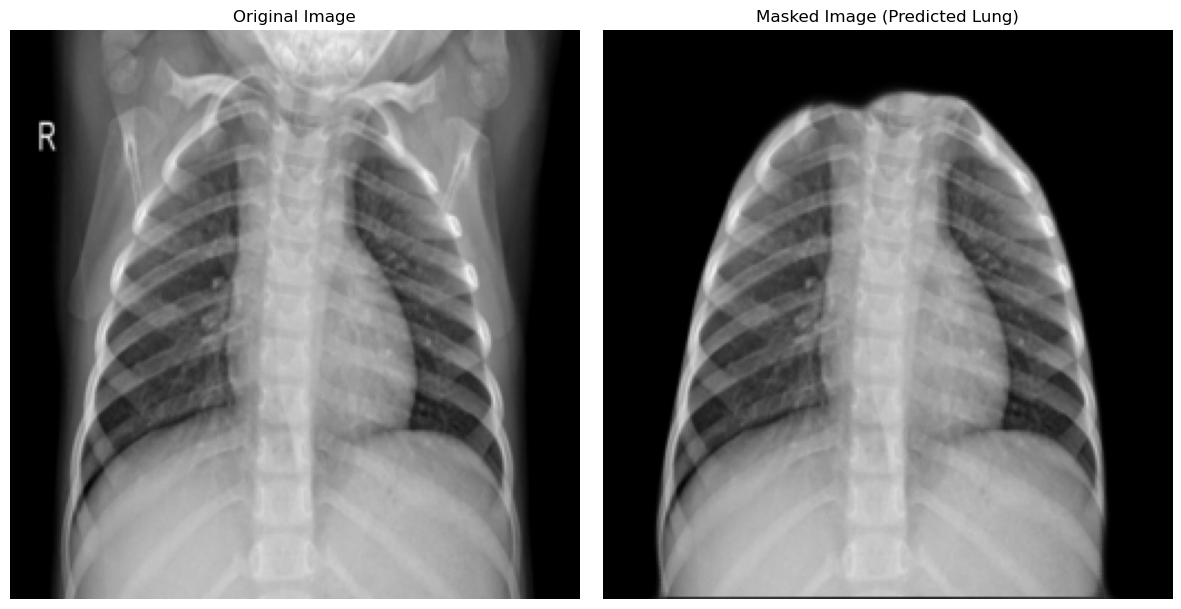

Processing image: ../data/masked/test\IM-0221-0001.jpeg, Original size: (1804, 1480)
Input tensor shape: torch.Size([1, 3, 256, 256])
Predicted mask shape: (256, 256)
Mask saved to: ../data/masked/test/masks\IM-0221-0001_mask.png


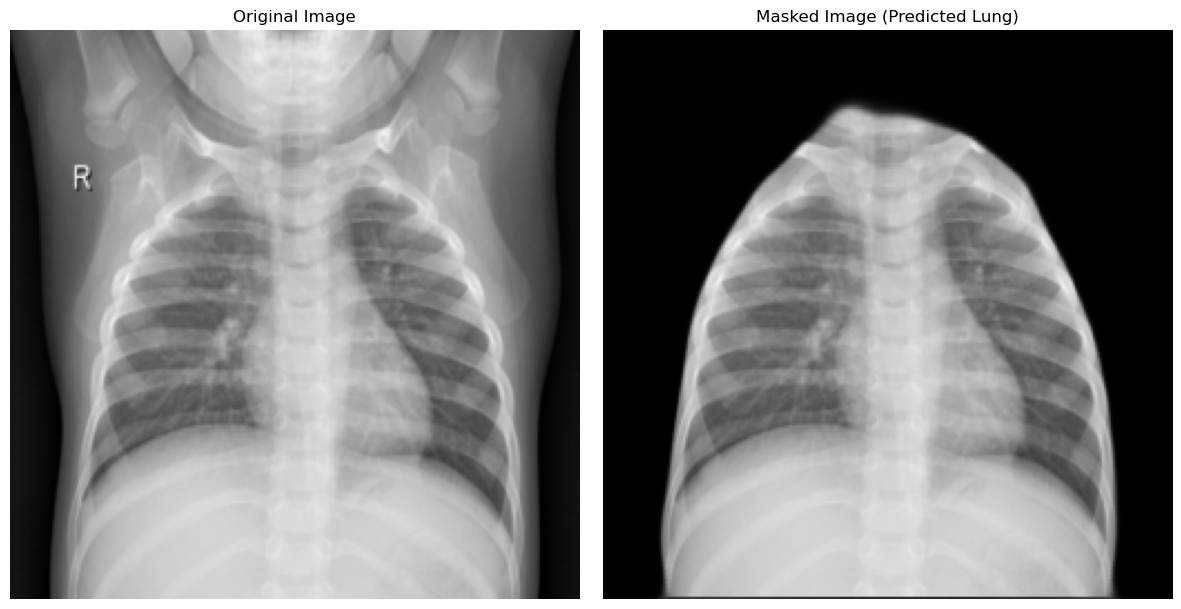

Processing image: ../data/masked/test\IM-0227-0001.jpeg, Original size: (1870, 1612)
Input tensor shape: torch.Size([1, 3, 256, 256])
Predicted mask shape: (256, 256)
Mask saved to: ../data/masked/test/masks\IM-0227-0001_mask.png


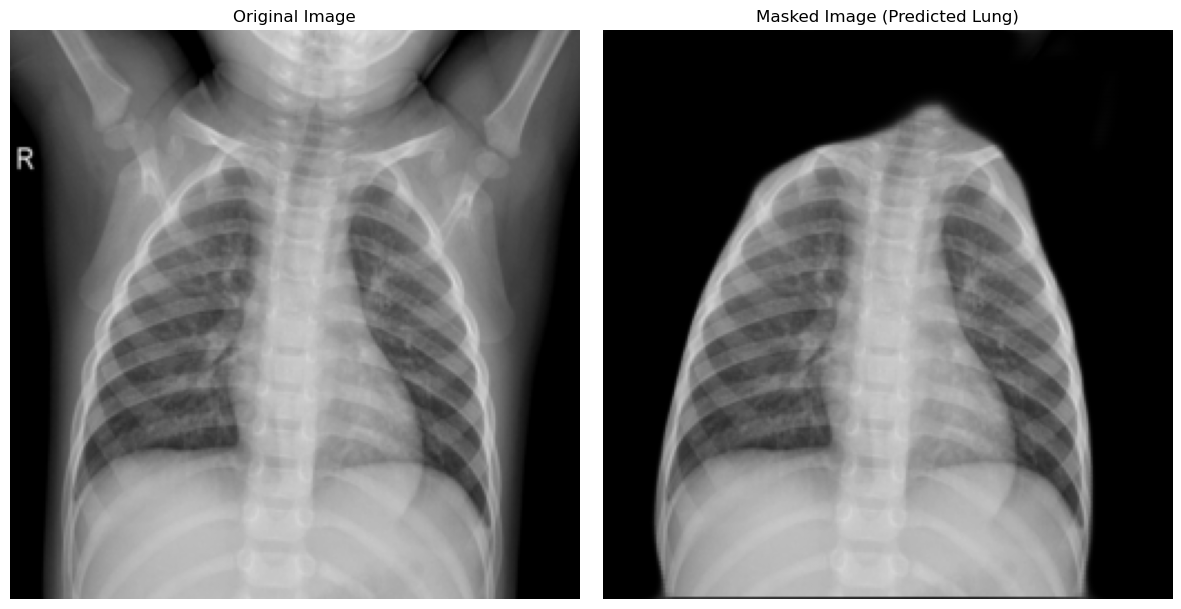

Processing image: ../data/masked/test\IM-0234-0001.jpeg, Original size: (1550, 1075)
Input tensor shape: torch.Size([1, 3, 256, 256])
Predicted mask shape: (256, 256)
Mask saved to: ../data/masked/test/masks\IM-0234-0001_mask.png


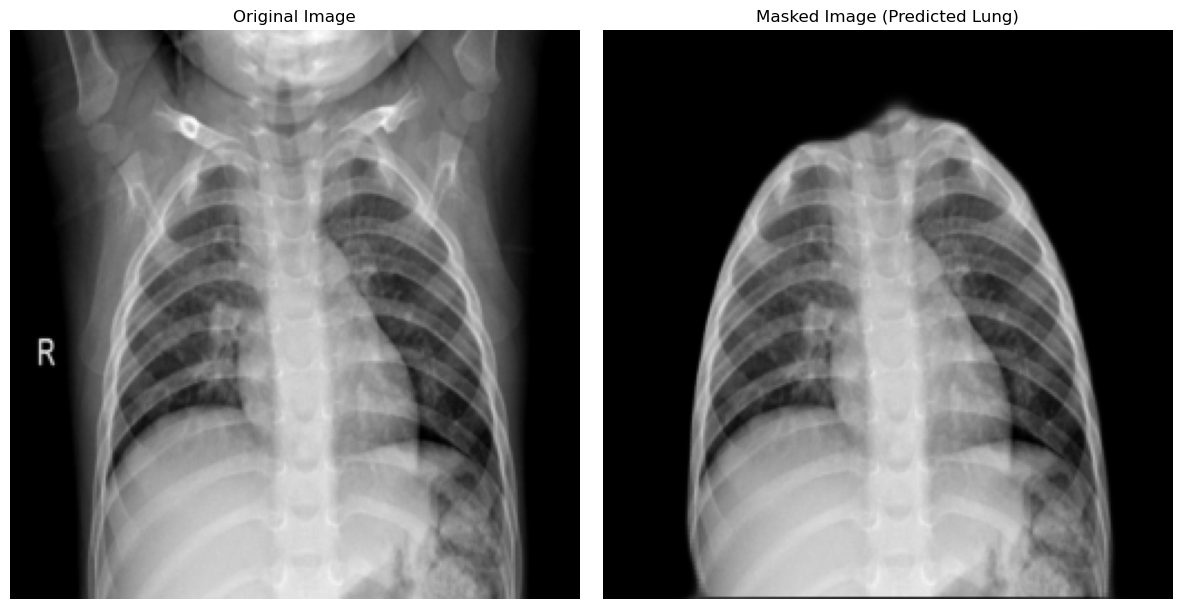

Processing image: ../data/masked/test\IM-0237-0001.jpeg, Original size: (1790, 1140)
Input tensor shape: torch.Size([1, 3, 256, 256])
Predicted mask shape: (256, 256)
Mask saved to: ../data/masked/test/masks\IM-0237-0001_mask.png


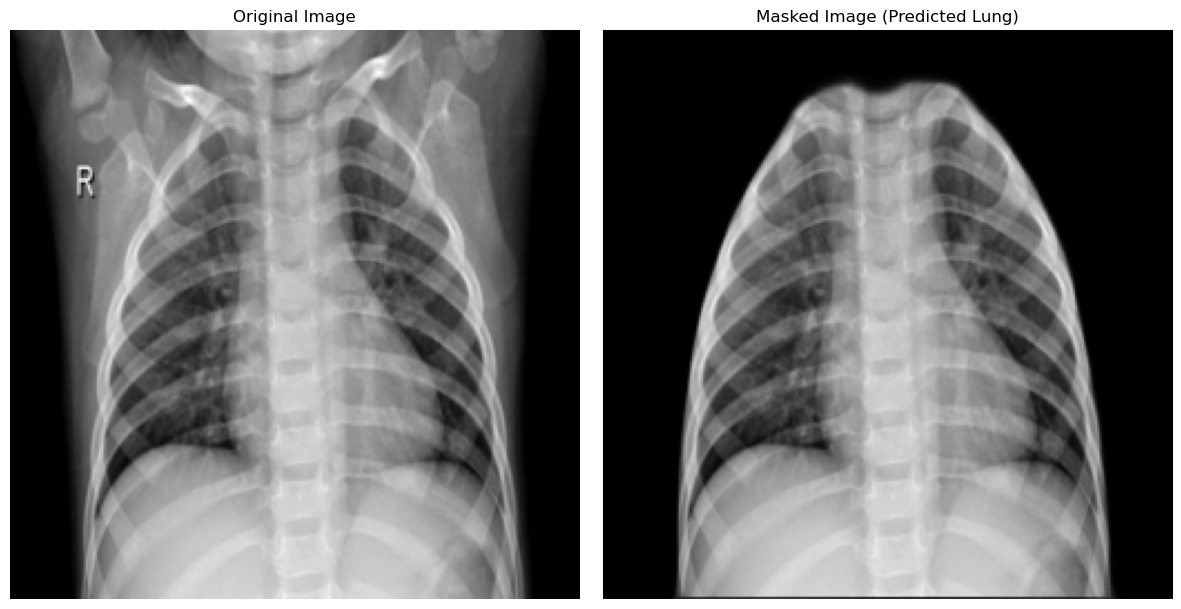

Error processing image masks: [Errno 13] Permission denied: 'C:\\Users\\aszab\\Documents\\Studium\\Modules\\ComputerScienceProject\\MedicalImaging\\pneumonia_detection\\data\\masked\\test\\masks'


In [46]:
# Test folder prediction
train_folder = "../data/processed"
output_folder = "../data/masked"
model.load_state_dict(torch.load("lung_segmentation_model.pth", map_location=device))
model.eval()
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
predict_and_visualize(train_folder, model, mask_transform, output_folder)

In [ ]:
# Test folder prediction
val_folder = "../data/masked/test"
output_folder = "../data/masked/test/masks"
predict_and_visualize(test_folder, model, mask_transform, output_folder)

In [ ]:
# Test folder prediction
test_folder = "../data/masked/test"
output_folder = "../data/masked/test/masks"
predict_and_visualize(test_folder, model, mask_transform, output_folder)